In [1]:
# === CELL 1: INSTALASI DAN IMPORT ===

# Instalasi library yang diperlukan
!pip install nltk
!pip install sastrawi
!pip install wordcloud

# Import library
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Download data NLTK (hanya perlu sekali)
nltk.download('punkt')
nltk.download('stopwords')

print("Library dan data NLTK siap digunakan.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Library dan data NLTK siap digunakan.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# === CELL 2: MUAT DATA & PEMBERSIHAN AWAL ===

# Tentukan nama file
file_path = "/content/drive/MyDrive/Dataset analisis sentimen/analisis_sentimen_youtube_purbaya_vs_srimulyani (1).csv"

# Muat data dengan delimiter koma (,) seperti yang kita temukan sebelumnya
try:
    df = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')

    # 1. Pilih kolom yang relevan
    df = df[['subjek', 'comment']].copy()

    # 2. Hapus baris dengan komentar kosong (NaN)
    df.dropna(subset=['comment'], inplace=True)

    # 3. Pastikan semua komentar adalah string
    df['comment'] = df['comment'].astype(str)

    # 4. HAPUS DUPLIKAT
    initial_rows = len(df)
    print(f"Jumlah baris awal (setelah dropna): {initial_rows}")
    df.drop_duplicates(subset=['comment'], inplace=True, keep='first')
    final_rows = len(df)
    print(f"Jumlah baris setelah hapus duplikat: {final_rows}")
    print(f"Total baris duplikat dihapus: {initial_rows - final_rows}")

    # Reset index
    df.reset_index(drop=True, inplace=True)

    print("\nData bersih (tanpa duplikat) siap diproses:")
    print(df.head())
    print(f"\nInfo Data:\n{df['subjek'].value_counts()}")

except Exception as e:
    print(f"Error saat memuat file: {e}")
    print("Pastikan file 'analisis_sentimen_youtube_purbaya_vs_srimulyani.csv' sudah di-upload.")

Jumlah baris awal (setelah dropna): 1727
Jumlah baris setelah hapus duplikat: 1714
Total baris duplikat dihapus: 13

Data bersih (tanpa duplikat) siap diproses:
                 subjek                                            comment
0  Purbaya Yudhi Sadewa  Ga perlu seperti punyanya sahroni,ya pak. Semu...
1  Purbaya Yudhi Sadewa  Apa arti FAMILY OFFICE dan manfaatnya lngsung ...
2  Purbaya Yudhi Sadewa  MENTERI PURBAYA YUDHI SADEWA SATU TYPE DGN  MA...
3  Purbaya Yudhi Sadewa  Pak purbaya tidak memikirkan kekayaan dirinya ...
4  Purbaya Yudhi Sadewa  Pak Purbaya bukan orang yg suka hal2 mubazier....

Info Data:
subjek
Purbaya Yudhi Sadewa     992
Sri Mulyani Indrawati    722
Name: count, dtype: int64


In [3]:
# === CELL 3: DEFINISI FUNGSI (NOISE REMOVAL & NORMALISASI) ===

# 1. Fungsi Noise Removal (Case Folding, Cleansing)
def remove_noise(text):
    text = text.lower() # Case folding
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\@\w+|\#\w+', '', text) # Hapus mention dan hashtag
    text = re.sub(r'&\w+;', '', text) # Hapus HTML entities
    text = re.sub(r'\d+', '', text) # Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text

# 2. Kamus Normalisasi (CONTOH)
# Anda HARUS melengkapi kamus ini sesuai kebutuhan data Anda
kamus_slang = {
    'yg': 'yang',
    'dgn': 'dengan',
    'utk': 'untuk',
    'smg': 'semoga',
    'jgn': 'jangan',
    'ga': 'tidak',
    'gak': 'tidak',
    'bgt': 'banget',
    'org': 'orang',
    'pak': 'bapak',
    'bu': 'ibu',
    'mentri': 'menteri',
    'klo': 'kalau',
    'kpd': 'kepada',
    'dpt': 'dapat',
    'ttp': 'tetap',
    'aja': 'saja',
    'sbg': 'sebagai',
    'sdh': 'sudah'
    # ... tambahkan lebih banyak kata ...
}

# 3. Fungsi Normalisasi
def normalize_text(text):
    words = text.split()
    normalized_words = [kamus_slang.get(word, word) for word in words]
    return ' '.join(normalized_words)

print("Fungsi 'remove_noise' dan 'normalize_text' siap.")

Fungsi 'remove_noise' dan 'normalize_text' siap.


In [4]:
# === CELL 4: DEFINISI FUNGSI (TOKEN, STOPWORD, STEMMING) ===

# 1. Siapkan Stopwords
list_stopwords = stopwords.words('indonesian')
# Tambah stopwords kustom jika perlu
list_stopwords.extend(['nya', 'sih', 'kok', 'deh', 'dong', 'ya', 'kan', 'tuh'])
# Ubah ke set untuk proses lebih cepat
stopword_set = set(list_stopwords)

# 2. Siapkan Stemmer (Sastrawi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 3. Fungsi Tokenisasi (sudah ada di NLTK: word_tokenize)

# 4. Fungsi Stopword Removal
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword_set and len(word) > 2] # Menghapus kata < 3 huruf

# 5. Fungsi Stemming
def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

print("Stopwords dan Stemmer (Sastrawi) siap.")
print("Fungsi 'remove_stopwords' dan 'stem_tokens' siap.")

Stopwords dan Stemmer (Sastrawi) siap.
Fungsi 'remove_stopwords' dan 'stem_tokens' siap.


In [6]:
# === CELL 5: JALANKAN PIPELINE PREPROCESSING ===
# === PERBAIKAN: JALANKAN INI DI SEL BARU ===
import nltk
nltk.download('punkt_tab')
# ========================================
print("Memulai proses preprocessing...")

# Terapkan Noise Removal & Normalization
print("Langkah 1/4: Noise Removal & Normalisasi...")
df['text_clean'] = df['comment'].apply(remove_noise)
df['text_normalized'] = df['text_clean'].apply(normalize_text)

# Terapkan Tokenisasi
print("Langkah 2/4: Tokenisasi...")
df['tokens'] = df['text_normalized'].apply(word_tokenize)

# Terapkan Stopword Removal
print("Langkah 3/4: Stopword Removal...")
df['tokens_no_stop'] = df['tokens'].apply(remove_stopwords)

# Terapkan Stemming
print("Langkah 4/4: Stemming...")
df['tokens_stemmed'] = df['tokens_no_stop'].apply(stem_tokens)

# Buat kolom final berisi teks bersih yang siap dianalisis
df['final_text'] = df['tokens_stemmed'].apply(lambda x: ' '.join(x))

print("\nProses preprocessing selesai!")
print("Contoh hasil akhir:")
print(df[['comment', 'final_text']].head())

# Simpan hasil preprocessing ke CSV baru (opsional tapi disarankan)
df.to_csv("analisis_komparatif_processed.csv", index=False)
print("\nHasil preprocessing disimpan ke 'analisis_komparatif_processed.csv'")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Memulai proses preprocessing...
Langkah 1/4: Noise Removal & Normalisasi...
Langkah 2/4: Tokenisasi...
Langkah 3/4: Stopword Removal...
Langkah 4/4: Stemming...

Proses preprocessing selesai!
Contoh hasil akhir:
                                             comment  \
0  Ga perlu seperti punyanya sahroni,ya pak. Semu...   
1  Apa arti FAMILY OFFICE dan manfaatnya lngsung ...   
2  MENTERI PURBAYA YUDHI SADEWA SATU TYPE DGN  MA...   
3  Pak purbaya tidak memikirkan kekayaan dirinya ...   
4  Pak Purbaya bukan orang yg suka hal2 mubazier....   

                                          final_text  
0  punya sahroniya brandid trilyunan otak kyk cek...  
1          arti family office manfaat lngsung rakyat  
2  menteri purbaya yudhi sadewa type marie muhamm...  
3  purbaya pikir kaya pikir rakyat yng mulya jala...  
4  purbaya orang suka mubazier milyaran planga pl...  

Hasil preprocessing disimpan ke 'analisis_komparatif_processed.csv'


In [14]:
# === CELL 5 (Bagian Akhir) - Modifikasi Pembersihan Final ===

# 1. Buat DataFrame baru yang hanya berisi kolom yang diinginkan
df_final = df[['subjek', 'final_text']].copy()
print(f"Jumlah baris awal: {len(df_final)}")

# 2. HAPUS MISSING VALUE (NaN)
# Menghapus baris jika 'subjek' atau 'final_text' adalah NaN
df_final.dropna(inplace=True)
print(f"Jumlah baris setelah .dropna(): {len(df_final)}")

# 3. HAPUS BARIS DENGAN 'final_text' KOSONG ("")
# (Penting! Ini berbeda dari NaN)
df_final = df_final[df_final['final_text'] != ""]
df_final.reset_index(drop=True, inplace=True) # Merapikan index
print(f"Jumlah baris setelah menghapus teks kosong: {len(df_final)}")

# 4. Simpan DataFrame final yang sudah bersih ini ke CSV
df_final.to_csv("analisis_komparatif_processed.csv", index=False)

print("\n-------------------------------------------------")
print("Hasil preprocessing (bersih dari NaN & teks kosong) \ntelah disimpan ke 'analisis_komparatif_processed.csv'")
print("-------------------------------------------------")
print(df_final.head())

Jumlah baris awal: 1714
Jumlah baris setelah .dropna(): 1714
Jumlah baris setelah menghapus teks kosong: 1683

-------------------------------------------------
Hasil preprocessing (bersih dari NaN & teks kosong) 
telah disimpan ke 'analisis_komparatif_processed.csv'
-------------------------------------------------
                 subjek                                         final_text
0  Purbaya Yudhi Sadewa  punya sahroniya brandid trilyunan otak kyk cek...
1  Purbaya Yudhi Sadewa          arti family office manfaat lngsung rakyat
2  Purbaya Yudhi Sadewa  menteri purbaya yudhi sadewa type marie muhamm...
3  Purbaya Yudhi Sadewa  purbaya pikir kaya pikir rakyat yng mulya jala...
4  Purbaya Yudhi Sadewa  purbaya orang suka mubazier milyaran planga pl...


In [16]:
# === CELL 8: PEMBERSIHAN AKHIR & EKSPOR KE CSV ===

print("Memulai proses pembersihan akhir dan ekspor...")

# 1. Pilih HANYA kolom 'subjek' dan 'final_text' dari DataFrame utama
df_final = df[['subjek', 'final_text']].copy()
print(f"Jumlah baris awal (sebelum pembersihan): {len(df_final)}")

# 2. Hapus baris jika 'subjek' atau 'final_text' adalah NaN (Missing Value)
df_final.dropna(inplace=True)
print(f"Jumlah baris setelah hapus NaN: {len(df_final)}")

# 3. Hapus baris jika 'final_text' adalah string kosong ("")
#    Ini penting karena "teks kosong" beda dengan "NaN"
df_final = df_final[df_final['final_text'] != ""]
print(f"Jumlah baris setelah hapus teks kosong: {len(df_final)}")

# 4. Merapikan index
df_final.reset_index(drop=True, inplace=True)

# 5. Simpan ke file CSV tanpa menyertakan index
df_final.to_csv("analisis_sentimen_bersih.csv", index=False)

print("\n-------------------------------------------------")
print("SUKSES: File 'analisis_komparatif_processed.csv' \ntelah disimpan.")
print("(File ini hanya berisi kolom 'subjek' & 'final_text' \nyang sudah bersih dari NaN dan teks kosong).")
print("-------------------------------------------------")

# Tampilkan 5 baris pertama dari data yang disimpan
print("\nContoh data yang disimpan:")
print(df_final.head())

Memulai proses pembersihan akhir dan ekspor...
Jumlah baris awal (sebelum pembersihan): 1714
Jumlah baris setelah hapus NaN: 1714
Jumlah baris setelah hapus teks kosong: 1683

-------------------------------------------------
SUKSES: File 'analisis_komparatif_processed.csv' 
telah disimpan.
(File ini hanya berisi kolom 'subjek' & 'final_text' 
yang sudah bersih dari NaN dan teks kosong).
-------------------------------------------------

Contoh data yang disimpan:
                 subjek                                         final_text
0  Purbaya Yudhi Sadewa  punya sahroniya brandid trilyunan otak kyk cek...
1  Purbaya Yudhi Sadewa          arti family office manfaat lngsung rakyat
2  Purbaya Yudhi Sadewa  menteri purbaya yudhi sadewa type marie muhamm...
3  Purbaya Yudhi Sadewa  purbaya pikir kaya pikir rakyat yng mulya jala...
4  Purbaya Yudhi Sadewa  purbaya orang suka mubazier milyaran planga pl...


In [9]:
# === CELL 6: ANALISIS N-GRAM (BI-GRAM & TRI-GRAM) - Versi Tabel ===

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Fungsi untuk mendapatkan N-grams teratas (tidak berubah)
def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Pisahkan data berdasarkan subjek (tidak berubah)
# Pastikan 'df' dan 'final_text' sudah ada dari sel sebelumnya
text_purbaya = df[df['subjek'] == 'Purbaya Yudhi Sadewa']['final_text'].dropna()
text_srimulyani = df[df['subjek'] == 'Sri Mulyani Indrawati']['final_text'].dropna()

# --- Analisis Bi-gram (2-kata) ---
print("--- Top 10 Bi-gram (Purbaya Yudhi Sadewa) ---")
top_bigrams_purbaya = get_top_ngrams(text_purbaya, ngram_range=(2, 2), top_n=10)
# Konversi ke DataFrame
df_bigram_purbaya = pd.DataFrame(top_bigrams_purbaya, columns=['Frasa', 'Jumlah'])
display(df_bigram_purbaya) # 'display' memberikan output tabel yang lebih baik di Colab

print("\n--- Top 10 Bi-gram (Sri Mulyani Indrawati) ---")
top_bigrams_srimulyani = get_top_ngrams(text_srimulyani, ngram_range=(2, 2), top_n=10)
# Konversi ke DataFrame
df_bigram_srimulyani = pd.DataFrame(top_bigrams_srimulyani, columns=['Frasa', 'Jumlah'])
display(df_bigram_srimulyani)

# --- Analisis Tri-gram (3-kata) ---
print("\n--- Top 10 Tri-gram (Purbaya Yudhi Sadewa) ---")
top_trigrams_purbaya = get_top_ngrams(text_purbaya, ngram_range=(3, 3), top_n=10)
# Konversi ke DataFrame
df_trigram_purbaya = pd.DataFrame(top_trigrams_purbaya, columns=['Frasa', 'Jumlah'])
display(df_trigram_purbaya)

print("\n--- Top 10 Tri-gram (Sri Mulyani Indrawati) ---")
top_trigrams_srimulyani = get_top_ngrams(text_srimulyani, ngram_range=(3, 3), top_n=10)
# Konversi ke DataFrame
df_trigram_srimulyani = pd.DataFrame(top_trigrams_srimulyani, columns=['Frasa', 'Jumlah'])
display(df_trigram_srimulyani)

--- Top 10 Bi-gram (Purbaya Yudhi Sadewa) ---


,Frasa,Jumlah
0,guru gembul,48
1,rakyat indonesia,22
2,menteri uang,18
3,pro rakyat,14
4,sri mulyani,12
5,presiden prabowo,11
6,masuk akal,10
7,menteri purbaya,8
8,purbaya orang,8
9,menkeu purbaya,8



--- Top 10 Bi-gram (Sri Mulyani Indrawati) ---


,Frasa,Jumlah
0,sri mulyani,67
1,menteri uang,16
2,naik pajak,12
3,uang negara,9
4,rakyat indonesia,9
5,bayar pajak,8
6,presiden prabowo,7
7,jeng sri,7
8,naikin pajak,7
9,mulyani menteri,6



--- Top 10 Tri-gram (Purbaya Yudhi Sadewa) ---


,Frasa,Jumlah
0,lindung allah swt,4
1,prediksi guru gembul,4
2,presiden prabowo subianto,4
3,sumber daya alam,4
4,pakai jam tangan,3
5,jam tangan mahal,3
6,moga allah swt,3
7,allah swt lindung,3
8,moga purbaya sehat,3
9,rakyat warga nkri,3



--- Top 10 Tri-gram (Sri Mulyani Indrawati) ---


,Frasa,Jumlah
0,sri mulyani menteri,5
1,sumber daya alam,5
2,kabinet merah putih,4
3,sesuai undang undang,4
4,mulyani menteri uang,3
5,sri mulyani indonesia,3
6,presiden prabowo gibran,3
7,sri mulyani lucu,3
8,daya alam sda,3
9,sri mulyani orang,2


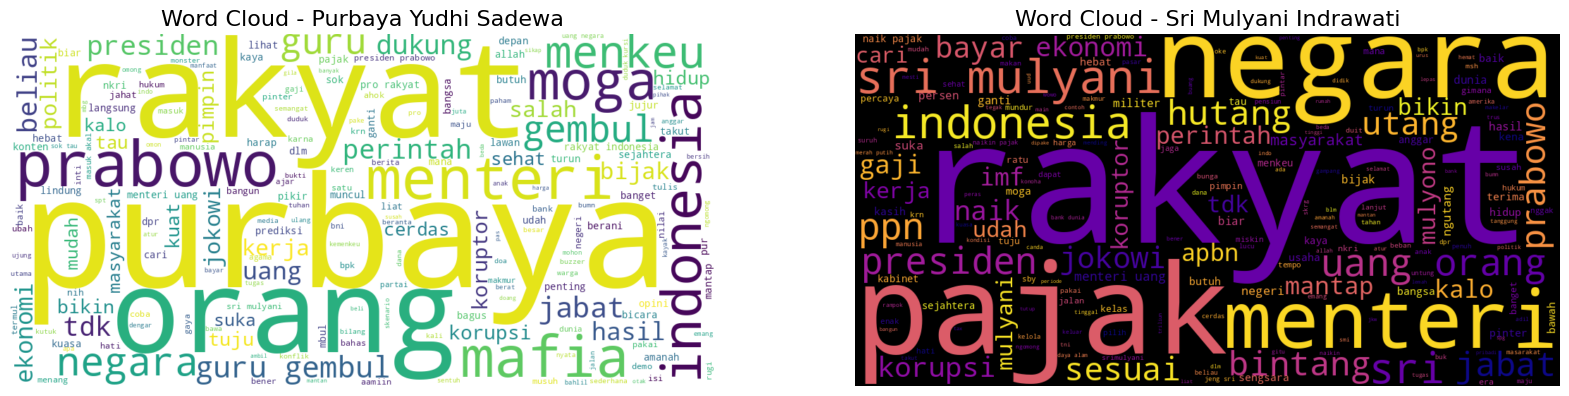

In [8]:
# === CELL 7: VISUALISASI WORD CLOUD ===

# Gabungkan semua teks bersih menjadi satu string besar untuk setiap subjek
text_purbaya_combined = " ".join(text_purbaya)
text_srimulyani_combined = " ".join(text_srimulyani)

# Cek apakah ada teks untuk digenerate
if text_purbaya_combined:
    # Buat Word Cloud untuk Purbaya
    wordcloud_purbaya = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_purbaya_combined)
else:
    print("Tidak ada data teks untuk Purbaya setelah diproses.")

if text_srimulyani_combined:
    # Buat Word Cloud untuk Sri Mulyani
    wordcloud_srimulyani = WordCloud(width=1000, height=500, background_color='black', colormap='plasma').generate(text_srimulyani_combined)
else:
    print("Tidak ada data teks untuk Sri Mulyani setelah diproses.")

# Tampilkan Word Clouds
plt.figure(figsize=(20, 10))

# Plot Purbaya
if 'wordcloud_purbaya' in locals():
    plt.subplot(1, 2, 1) # (1 baris, 2 kolom, gambar ke-1)
    plt.imshow(wordcloud_purbaya, interpolation='bilinear')
    plt.title('Word Cloud - Purbaya Yudhi Sadewa', fontsize=16)
    plt.axis('off')

# Plot Sri Mulyani
if 'wordcloud_srimulyani' in locals():
    plt.subplot(1, 2, 2) # (1 baris, 2 kolom, gambar ke-2)
    plt.imshow(wordcloud_srimulyani, interpolation='bilinear')
    plt.title('Word Cloud - Sri Mulyani Indrawati', fontsize=16)
    plt.axis('off')

plt.show()

Tabel berhasil disimpan sebagai: top_bigrams_purbaya.png
Tabel berhasil disimpan sebagai: top_bigrams_srimulyani.png
Tabel berhasil disimpan sebagai: top_trigrams_purbaya.png
Tabel berhasil disimpan sebagai: top_trigrams_srimulyani.png

--- Menampilkan Gambar Tabel ---


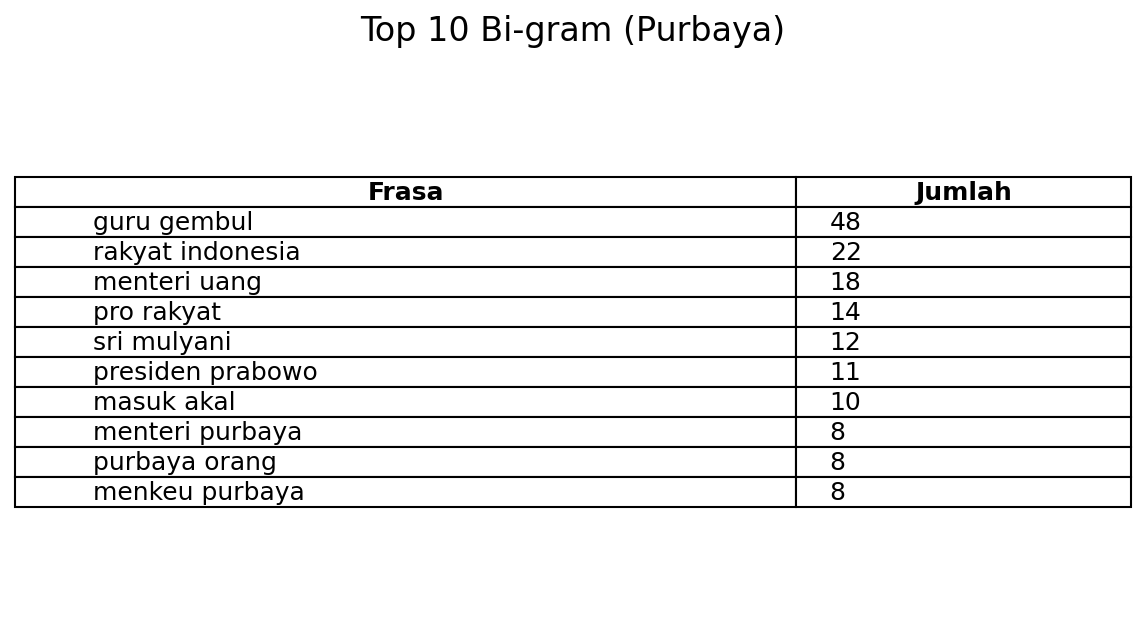

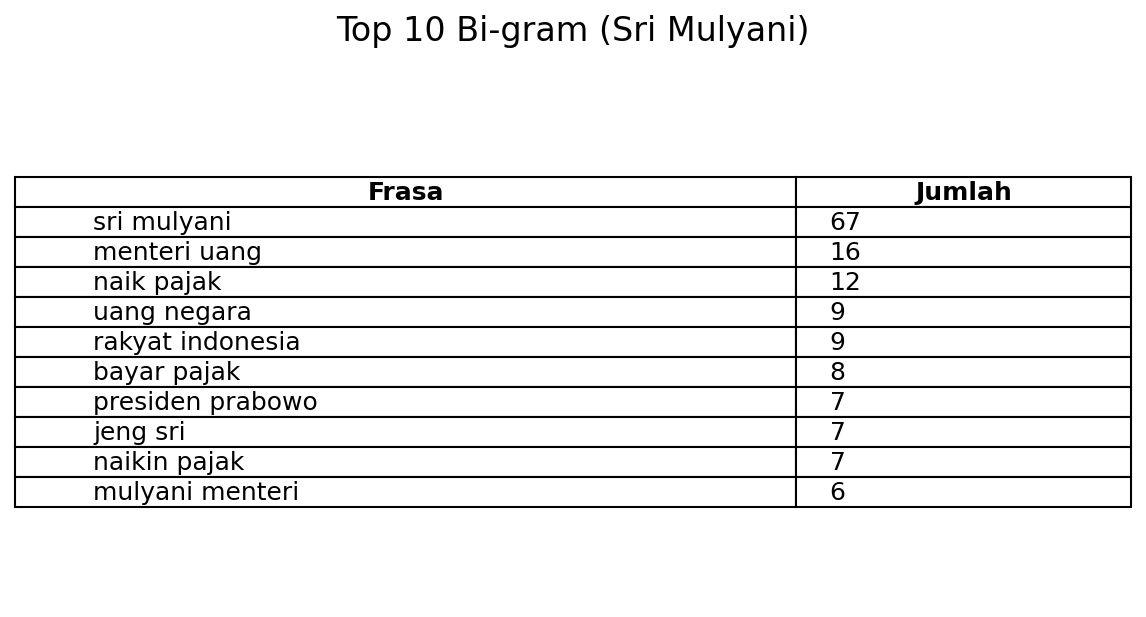

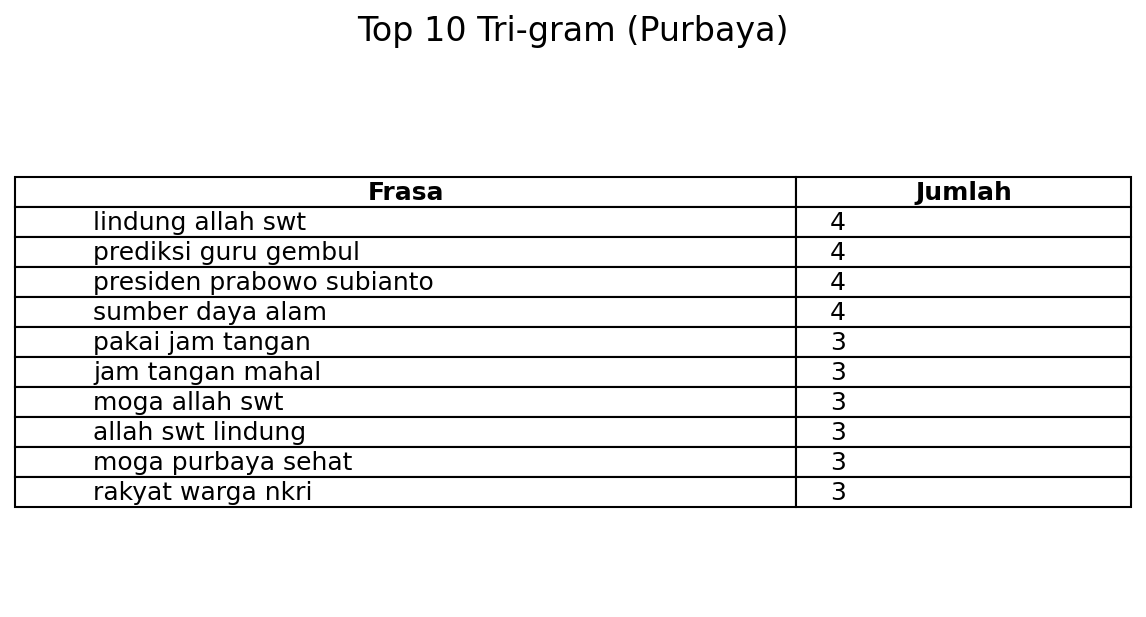

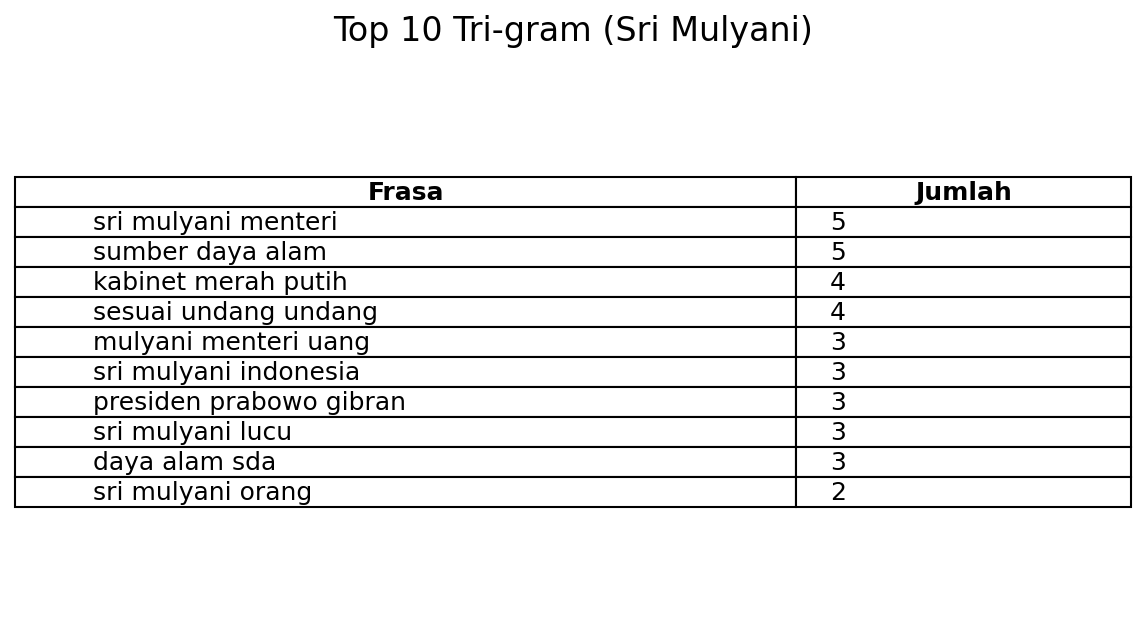

In [17]:
# === CELL 6: ANALISIS N-GRAM (Disimpan sebagai Gambar) ===

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display # Untuk menampilkan gambar di Colab

# --- Fungsi Baru: Menyimpan DataFrame sebagai Gambar ---
def save_df_as_image(df, title, filename):
    """
    Menyimpan DataFrame pandas sebagai gambar PNG menggunakan matplotlib.
    """
    # Reset index agar index tidak ikut tergambar sebagai kolom
    df_plot = df.reset_index(drop=True)

    # Tentukan ukuran gambar berdasarkan jumlah baris
    # (tinggi_dasar + tinggi_per_baris)
    fig_height = 0.5 + len(df_plot) * 0.4

    # Buat figure
    fig, ax = plt.subplots(figsize=(8, fig_height)) # Lebar 8, tinggi dinamis

    # Sembunyikan sumbu X dan Y
    ax.axis('off')

    # Buat tabel
    table = ax.table(cellText=df_plot.values,
                     colLabels=df_plot.columns,
                     loc='center',
                     cellLoc='left',  # Ratakan kiri teks di sel
                     colWidths=[0.7, 0.3]) # Lebar kolom (Frasa 70%, Jumlah 30%)

    # Styling tabel
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2) # Perbesar skala tabel

    # Beri style BOLD pada header
    for (i, j), cell in table.get_celld().items():
        if i == 0: # Jika ini baris header
            cell.set_text_props(weight='bold')

    # Set judul gambar
    ax.set_title(title, fontsize=16, pad=20)

    # Simpan gambar
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    print(f"Tabel berhasil disimpan sebagai: {filename}")

    # Tutup plot agar tidak tumpang tindih
    plt.close(fig)

# --- Fungsi get_top_ngrams (Tidak Berubah) ---
def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# --- Proses Utama N-Gram ---

# Pisahkan data (pastikan 'df' dan 'final_text' ada dari Cell 5)
text_purbaya = df[df['subjek'] == 'Purbaya Yudhi Sadewa']['final_text'].dropna()
text_srimulyani = df[df['subjek'] == 'Sri Mulyani Indrawati']['final_text'].dropna()

# --- 1. Bi-gram Purbaya ---
top_bigrams_purbaya = get_top_ngrams(text_purbaya, ngram_range=(2, 2), top_n=10)
df_bigram_purbaya = pd.DataFrame(top_bigrams_purbaya, columns=['Frasa', 'Jumlah'])
save_df_as_image(df_bigram_purbaya, 'Top 10 Bi-gram (Purbaya)', 'top_bigrams_purbaya.png')

# --- 2. Bi-gram Sri Mulyani ---
top_bigrams_srimulyani = get_top_ngrams(text_srimulyani, ngram_range=(2, 2), top_n=10)
df_bigram_srimulyani = pd.DataFrame(top_bigrams_srimulyani, columns=['Frasa', 'Jumlah'])
save_df_as_image(df_bigram_srimulyani, 'Top 10 Bi-gram (Sri Mulyani)', 'top_bigrams_srimulyani.png')

# --- 3. Tri-gram Purbaya ---
top_trigrams_purbaya = get_top_ngrams(text_purbaya, ngram_range=(3, 3), top_n=10)
df_trigram_purbaya = pd.DataFrame(top_trigrams_purbaya, columns=['Frasa', 'Jumlah'])
save_df_as_image(df_trigram_purbaya, 'Top 10 Tri-gram (Purbaya)', 'top_trigrams_purbaya.png')

# --- 4. Tri-gram Sri Mulyani ---
top_trigrams_srimulyani = get_top_ngrams(text_srimulyani, ngram_range=(3, 3), top_n=10)
df_trigram_srimulyani = pd.DataFrame(top_trigrams_srimulyani, columns=['Frasa', 'Jumlah'])
save_df_as_image(df_trigram_srimulyani, 'Top 10 Tri-gram (Sri Mulyani)', 'top_trigrams_srimulyani.png')

# --- Tampilkan Semua Gambar yang Telah Disimpan ---
print("\n--- Menampilkan Gambar Tabel ---")
display(Image('top_bigrams_purbaya.png', width=500))
display(Image('top_bigrams_srimulyani.png', width=500))
display(Image('top_trigrams_purbaya.png', width=500))
display(Image('top_trigrams_srimulyani.png', width=500))